# Unsupervised Learning Trading Strategy

> "I just want to try to apply this strategy for VN Securities. All the code and strategy are based on the project learned"

* Download/Load VN30 stocks prices data.
* Calculate different features and indicators on each stock.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to VN30 returns.


# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load VN30 stocks prices data.

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')
import requests

url = "https://www.tradingview.com/symbols/HOSE-VN30/components/"  # Set headers to mimic a real browser
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}


response = requests.get(url, headers=headers) # Get the HTML page with requests
response.raise_for_status()


vn100 = pd.read_html(response.text)[0]  # Parse tables with pandas

vn100['Symbol_prefix'] = vn100['Symbol'].str[:3]  # Lấy 3 ký tự đầu tiên

symbols_list = vn100['Symbol_prefix'].unique().tolist()

vn_symbols_list=[symbol + '.VN' for symbol in symbols_list]
end_date = '2025-08-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8) # How about if i get more than 8 years of data?

df = yf.download(tickers = vn_symbols_list, 
                 start=start_date, 
                 end=end_date,
                 auto_adjust=False).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  30 of 30 completed


Price                  adj close          close           high            low  \
date       ticker                                                               
2017-08-28 ACB.VN    5116.395508    5609.886719    5649.254395    5432.732422   
           BID.VN   11458.047852   11458.047852   11603.824219   11399.737305   
           CTG.VN   13069.928711   13069.928711   13104.597656   12931.255859   
           FPT.VN   14944.609375   15589.995117   15589.995117   15475.363281   
           GAS.VN   42784.843750   49971.445312   50050.765625   48702.328125   
...                          ...            ...            ...            ...   
2025-08-22 VIC.VN  124100.000000  124100.000000  127500.000000  122000.000000   
           VJC.VN  140000.000000  140000.000000  145000.000000  138000.000000   
           VNM.VN   58700.000000   58700.000000   59900.000000   58500.000000   
           VPB.VN   35950.000000   35950.000000   38250.000000   35950.000000   
           VRE.VN   30000.000000   30000.000000   30100.000000   28650.000000   

Price                       open      volume  
date       ticker                             
2017-08-28 ACB.VN    5432.732422  13459342.0  
           BID.VN   11516.358398   2040122.0  
           CTG.VN   13069.928711   1510243.0  
           FPT.VN   15491.739258   1929914.0  
           GAS.VN   48702.328125    734857.0  
...                          ...         ...  
2025-08-22 VIC.VN  122000.000000   5042251.0  
           VJC.VN  140500.000000   3400757.0  
           VNM.VN   59800.000000   7210343.0  
           VPB.VN   38000.000000  75606560.0  
           VRE.VN   29850.000000  10655500.0  

[37654 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* VND Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [3]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['vnd_volume'] = (df['adj close']*df['volume'])/1e6

df


Price                  adj close          close           high            low  \
date       ticker                                                               
2017-08-28 ACB.VN    5116.395508    5609.886719    5649.254395    5432.732422   
           BID.VN   11458.047852   11458.047852   11603.824219   11399.737305   
           CTG.VN   13069.928711   13069.928711   13104.597656   12931.255859   
           FPT.VN   14944.609375   15589.995117   15589.995117   15475.363281   
           GAS.VN   42784.843750   49971.445312   50050.765625   48702.328125   
...                          ...            ...            ...            ...   
2025-08-22 VIC.VN  124100.000000  124100.000000  127500.000000  122000.000000   
           VJC.VN  140000.000000  140000.000000  145000.000000  138000.000000   
           VNM.VN   58700.000000   58700.000000   59900.000000   58500.000000   
           VPB.VN   35950.000000   35950.000000   38250.000000   35950.000000   
           VRE.VN   30000.000000   30000.000000   30100.000000   28650.000000   

Price                       open      volume  garman_klass_vol        rsi  \
date       ticker                                                           
2017-08-28 ACB.VN    5432.732422  13459342.0         -0.000627        NaN   
           BID.VN   11516.358398   2040122.0          0.000147        NaN   
           CTG.VN   13069.928711   1510243.0          0.000089        NaN   
           FPT.VN   15491.739258   1929914.0         -0.000472        NaN   
           GAS.VN   48702.328125    734857.0         -0.006110        NaN   
...                          ...         ...               ...        ...   
2025-08-22 VIC.VN  122000.000000   5042251.0          0.000860  64.997338   
           VJC.VN  140500.000000   3400757.0          0.001219  66.046983   
           VNM.VN   59800.000000   7210343.0          0.000147  43.385949   
           VPB.VN   38000.000000  75606560.0          0.000735  76.866181   
           VRE.VN   29850.000000  10655500.0          0.001209  57.949607   

Price                 bb_low     bb_mid    bb_high       atr      macd  \
date       ticker                                                        
2017-08-28 ACB.VN        NaN        NaN        NaN       NaN       NaN   
           BID.VN        NaN        NaN        NaN       NaN       NaN   
           CTG.VN        NaN        NaN        NaN       NaN       NaN   
           FPT.VN        NaN        NaN        NaN       NaN       NaN   
           GAS.VN        NaN        NaN        NaN       NaN       NaN   
...                      ...        ...        ...       ...       ...   
2025-08-22 VIC.VN  11.566885  11.660316  11.753747  2.420500  1.477673   
           VJC.VN  11.633655  11.778520  11.923386  4.824330  4.707230   
           VNM.VN  10.983062  11.019463  11.055864  0.244759  0.056420   
           VPB.VN  10.017625  10.285257  10.552889  6.599692  6.651516   
           VRE.VN  10.237805  10.294572  10.351339  1.827803  1.017642   

Price                vnd_volume  
date       ticker                
2017-08-28 ACB.VN  6.886332e+04  
           BID.VN  2.337582e+04  
           CTG.VN  1.973877e+04  
           FPT.VN  2.884181e+04  
           GAS.VN  3.144074e+04  
...                         ...  
2025-08-22 VIC.VN  6.257433e+05  
           VJC.VN  4.761060e+05  
           VNM.VN  4.232471e+05  
           VPB.VN  2.718056e+06  
           VRE.VN  3.196650e+05  

[37654 rows x 14 columns]

In [4]:
#Check out Value 
df.xs('ACB.VN',level=1)['rsi'].plot()

<Axes: xlabel='date'>

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month. (Option)

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['vnd_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['vnd_volume'].resample('M').mean().stack('ticker').to_frame('vnd_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

vnd_volume      adj close  garman_klass_vol        rsi  \
date       ticker                                                             
2017-10-31 ACB.VN  1.578898e+05    5493.393066         -0.005580  49.194819   
           BID.VN  4.698302e+04   12740.882812          0.000442  64.033993   
           CTG.VN  2.999122e+04   13000.592773          0.000063  46.092722   
           FPT.VN  7.589318e+04   15823.703125          0.000181  58.414085   
           GAS.VN  4.137449e+04   48557.402344         -0.011239  59.321271   
...                         ...            ...               ...        ...   
2025-08-31 VIC.VN  1.361526e+06  124100.000000          0.000860  64.997338   
           VJC.VN  4.914632e+05  140000.000000          0.001219  66.046983   
           VNM.VN  3.666202e+05   58700.000000          0.000147  43.385949   
           VPB.VN  1.955287e+06   35950.000000          0.000735  76.866181   
           VRE.VN  2.195291e+05   30000.000000          0.001209  57.949607   

                      bb_low     bb_mid    bb_high       atr      macd  
date       ticker                                                       
2017-10-31 ACB.VN   8.602453   8.646863   8.691273 -0.930670  0.018258  
           BID.VN   9.337628   9.399792   9.461956 -1.715315  0.127605  
           CTG.VN   9.465186   9.489543   9.513900 -1.665886 -0.212694  
           FPT.VN   9.620358   9.659269   9.698180 -1.002159 -0.187889  
           GAS.VN  10.720181  10.759224  10.798266 -0.640848  0.374534  
...                      ...        ...        ...       ...       ...  
2025-08-31 VIC.VN  11.566885  11.660316  11.753747  2.420500  1.477673  
           VJC.VN  11.633655  11.778520  11.923386  4.824330  4.707230  
           VNM.VN  10.983062  11.019463  11.055864  0.244759  0.056420  
           VPB.VN  10.017625  10.285257  10.552889  6.599692  6.651516  
           VRE.VN  10.237805  10.294572  10.351339  1.827803  1.017642  

[1802 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [6]:
data['vnd_volume'] = (data.loc[:, 'vnd_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['vnd_vol_rank'] = (data.groupby('date')['vnd_volume'].rank(ascending=False))

data = data[data['vnd_vol_rank']<150].drop(['vnd_volume', 'vnd_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi     bb_low  \
date       ticker                                                          
2018-09-30 ACB.VN    7743.979492         -0.002916  56.455546   8.906080   
           BID.VN   20525.357422          0.000336  61.164763   9.859760   
           CTG.VN   19102.203125          0.000184  57.507285   9.786100   
           FPT.VN   16716.929688         -0.000824  62.734238   9.624477   
           GAS.VN   78574.703125         -0.011630  67.027144  11.093066   
...                          ...               ...        ...        ...   
2025-08-31 VIC.VN  124100.000000          0.000860  64.997338  11.566885   
           VJC.VN  140000.000000          0.001219  66.046983  11.633655   
           VNM.VN   58700.000000          0.000147  43.385949  10.983062   
           VPB.VN   35950.000000          0.000735  76.866181  10.017625   
           VRE.VN   30000.000000          0.001209  57.949607  10.237805   

                      bb_mid    bb_high       atr      macd  
date       ticker                                            
2018-09-30 ACB.VN   8.937286   8.968491 -1.057216  0.078374  
           BID.VN   9.910151   9.960543 -0.670831  0.712371  
           CTG.VN   9.835657   9.885214 -0.798271  0.424098  
           FPT.VN   9.684529   9.744582 -1.023327 -0.042843  
           GAS.VN  11.212406  11.331746  0.415395  2.188866  
...                      ...        ...       ...       ...  
2025-08-31 VIC.VN  11.660316  11.753747  2.420500  1.477673  
           VJC.VN  11.778520  11.923386  4.824330  4.707230  
           VNM.VN  11.019463  11.055864  0.244759  0.056420  
           VPB.VN  10.285257  10.552889  6.599692  6.651516  
           VRE.VN  10.294572  10.351339  1.827803  1.017642  

[1472 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [7]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi     bb_low  \
date       ticker                                                          
2019-09-30 ACB.VN    6908.265137         -0.002832  61.592086   8.751680   
           BID.VN   22974.406250          0.000332  57.895751   9.993463   
           CTG.VN   14664.667969          0.000127  58.556201   9.512459   
           FPT.VN   22916.271484         -0.001401  62.674546   9.938441   
           GAS.VN   72190.937500         -0.007618  57.665233  11.102542   
...                          ...               ...        ...        ...   
2025-08-31 VIC.VN  124100.000000          0.000860  64.997338  11.566885   
           VJC.VN  140000.000000          0.001219  66.046983  11.633655   
           VNM.VN   58700.000000          0.000147  43.385949  10.983062   
           VPB.VN   35950.000000          0.000735  76.866181  10.017625   
           VRE.VN   30000.000000          0.001209  57.949607  10.237805   

                      bb_mid    bb_high       atr      macd  return_1m  \
date       ticker                                                        
2019-09-30 ACB.VN   8.803290   8.854899 -0.968798  0.069390   0.054054   
           BID.VN  10.042701  10.091939 -1.078891  0.543232   0.016774   
           CTG.VN   9.564034   9.615609 -1.725622  0.020857   0.047030   
           FPT.VN  10.008507  10.078572 -0.696773  0.226908   0.086629   
           GAS.VN  11.148223  11.193904 -0.417588  0.251803   0.056660   
...                      ...        ...       ...       ...        ...   
2025-08-31 VIC.VN  11.660316  11.753747  2.420500  1.477673   0.176303   
           VJC.VN  11.778520  11.923386  4.824330  4.707230   0.155116   
           VNM.VN  11.019463  11.055864  0.244759  0.056420  -0.040850   
           VPB.VN  10.285257  10.552889  6.599692  6.651516   0.393411   
           VRE.VN  10.294572  10.351339  1.827803  1.017642   0.067616   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-09-30 ACB.VN   0.013072   0.017233   0.000659   0.003041   -0.009471  
           BID.VN   0.053499   0.075175   0.016098   0.015193    0.009438  
           CTG.VN   0.009593   0.027445  -0.009893   0.010222   -0.021789  
           FPT.VN   0.091856   0.082401   0.057043   0.046394    0.026634  
           GAS.VN  -0.012916   0.029223   0.013297   0.023035   -0.007036  
...                      ...        ...        ...        ...         ...  
2025-08-31 VIC.VN   0.139349   0.080419   0.200811   0.132060    0.089789  
           VJC.VN   0.256313   0.169412   0.063860   0.035003    0.023960  
           VNM.VN   0.006016   0.022559  -0.003847  -0.005893   -0.012680  
           VPB.VN   0.383986   0.256280   0.112460   0.074901    0.057044  
           VRE.VN   0.103195   0.029428   0.094939   0.058912    0.037876  

[1112 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 ACB.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.054054
           BID.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.016774
           CTG.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.047030
           FPT.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.086629
           GAS.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.056660
...                   ...     ...     ...     ...     ...        ...
2025-06-30 SSI.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053305
           TCB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.123153
           TPB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.015094
           VCB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.010638
           VIB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.022346

[1052 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [9]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 ACB.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.054054
           BID.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.016774
           CTG.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.047030
           FPT.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.086629
           GAS.VN  0.0142  0.0029  0.0676  0.0182  0.0338   0.056660
...                   ...     ...     ...     ...     ...        ...
2025-06-30 SSI.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053305
           TCB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.123153
           TPB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.015094
           VCB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.010638
           VIB.VN  0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.022346

[1052 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [10]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-09-30 ACB.VN       NaN       NaN       NaN       NaN       NaN
           BID.VN       NaN       NaN       NaN       NaN       NaN
           CTG.VN       NaN       NaN       NaN       NaN       NaN
           FPT.VN       NaN       NaN       NaN       NaN       NaN
           GAS.VN       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-06-30 SSI.VN  1.474523 -1.107198  0.935014  0.263019  0.421734
           TCB.VN  1.126883 -0.109745 -0.353923  0.432723  1.401095
           TPB.VN  0.810435  0.135838 -0.662967  0.051476  0.826255
           VCB.VN  0.219251 -0.195618  0.245467  0.061961  0.235433
           VIB.VN  1.191289 -0.270451  0.671479  0.490034  0.326154

[1052 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [11]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1086 entries, (Timestamp('2019-09-30 00:00:00'), 'ACB.VN') to (Timestamp('2025-08-31 00:00:00'), 'VIB.VN')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  1086 non-null   float64
 1   rsi               1086 non-null   float64
 2   bb_low            1086 non-null   float64
 3   bb_mid            1086 non-null   float64
 4   bb_high           1086 non-null   float64
 5   atr               1086 non-null   float64
 6   macd              1086 non-null   float64
 7   return_1m         1086 non-null   float64
 8   return_2m         1086 non-null   float64
 9   return_3m         1086 non-null   float64
 10  return_6m         1086 non-null   float64
 11  return_9m         1086 non-null   float64
 12  return_12m        1086 non-null   float64
 13  Mkt-RF            1086 non-null   float64
 14  SMB               1086 non-null   float64
 15  HML   

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [12]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [13]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

  File "c:\Users\VAQ\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\VAQ\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VAQ\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\VAQ\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


garman_klass_vol        rsi     bb_low     bb_mid  \
date       ticker                                                      
2019-09-30 ACB.VN         -0.002832  61.592086   8.751680   8.803290   
           BID.VN          0.000332  57.895751   9.993463  10.042701   
           CTG.VN          0.000127  58.556201   9.512459   9.564034   
           FPT.VN         -0.001401  62.674546   9.938441  10.008507   
           GAS.VN         -0.007618  57.665233  11.102542  11.148223   
...                             ...        ...        ...        ...   
2025-08-31 SSI.VN          0.000663  60.953049  10.406094  10.477803   
           TCB.VN          0.001339  60.131912  10.413097  10.525276   
           TPB.VN          0.005268  74.378015   9.604660   9.828292   
           VCB.VN          0.001397  61.590122  10.996254  11.043933   
           VIB.VN          0.006366  84.427872   9.785035   9.910354   

                     bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                        
2019-09-30 ACB.VN   8.854899 -0.968798  0.069390   0.054054   0.013072   
           BID.VN  10.091939 -1.078891  0.543232   0.016774   0.053499   
           CTG.VN   9.615609 -1.725622  0.020857   0.047030   0.009593   
           FPT.VN  10.078572 -0.696773  0.226908   0.086629   0.091856   
           GAS.VN  11.193904 -0.417588  0.251803   0.056660  -0.012916   
...                      ...       ...       ...        ...        ...   
2025-08-31 SSI.VN  10.549512  2.430692  2.039079   0.045322   0.203066   
           TCB.VN  10.637455  4.463379  2.813709   0.147059   0.067872   
           TPB.VN  10.051923  3.132023  5.101035   0.372418   0.242225   
           VCB.VN  11.091612  2.665501  1.184217   0.073090   0.064581   
           VIB.VN  10.035673  2.126395  3.146495   0.216495   0.191813   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2019-09-30 ACB.VN   0.017233   0.000659   0.003041   -0.009471  0.465049   
           BID.VN   0.075175   0.016098   0.015193    0.009438  0.864136   
           CTG.VN   0.027445  -0.009893   0.010222   -0.021789  0.883022   
           FPT.VN   0.082401   0.057043   0.046394    0.026634  0.457950   
           GAS.VN   0.029223   0.013297   0.023035   -0.007036  0.557231   
...                      ...        ...        ...         ...       ...   
2025-08-31 SSI.VN   0.150918   0.052495   0.042644    0.023415  1.255730   
           TCB.VN   0.085990   0.069229   0.057400    0.043674  0.747276   
           TPB.VN   0.156008   0.056099   0.040566    0.037383  0.729768   
           VCB.VN   0.046288   0.005770   0.003843    0.004328  0.484411   
           VIB.VN   0.134951   0.052006   0.043380    0.036233  1.200087   

                        SMB       HML       RMW       CMA  cluster  
date       ticker                                                   
2019-09-30 ACB.VN  0.722589 -0.015059  0.268291 -0.440731        2  
           BID.VN -0.115945  0.407975 -0.354136 -0.233694        2  
           CTG.VN  0.104439  0.320068  0.233602 -0.248155        2  
           FPT.VN  0.190177  0.198692 -0.298038 -0.440675        2  
           GAS.VN -0.352598  1.019579 -0.780759 -1.073055        2  
...                     ...       ...       ...       ...      ...  
2025-08-31 SSI.VN  0.516457 -0.658606  0.312171 -0.308228        2  
           TCB.VN  0.057319 -0.223974 -0.360956 -0.167004        2  
           TPB.VN  0.238416 -0.039155 -0.594381  0.156771        3  
           VCB.VN  0.181482 -0.155397 -0.392744  0.035031        2  
           VIB.VN  0.061726  0.072314  0.100984 -0.008193        3  

[1086 rows x 19 columns]

In [14]:
def plot_clusters(data, ax=None):
    if ax is None:
        ax = plt.gca()  # nếu không truyền thì lấy trục hiện tại

    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    ax.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color='red', label='cluster 0')
    ax.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color='green', label='cluster 1')
    ax.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color='blue', label='cluster 2')
    ax.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color='black', label='cluster 3')

    ax.legend()
    return ax


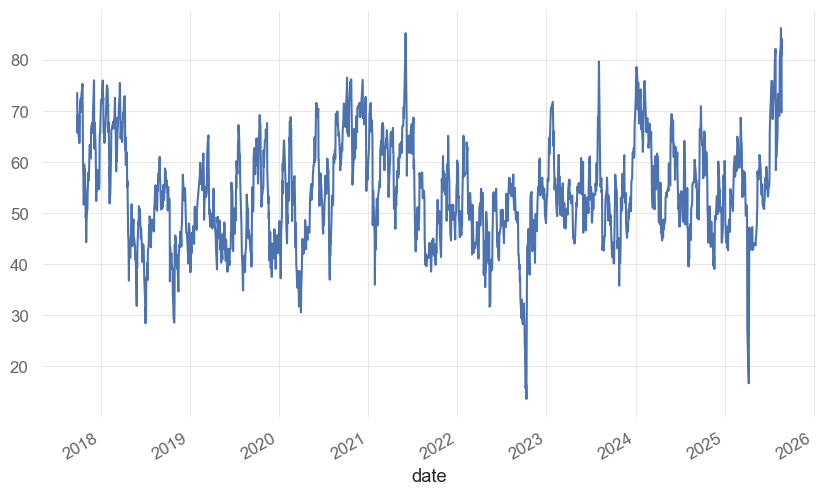

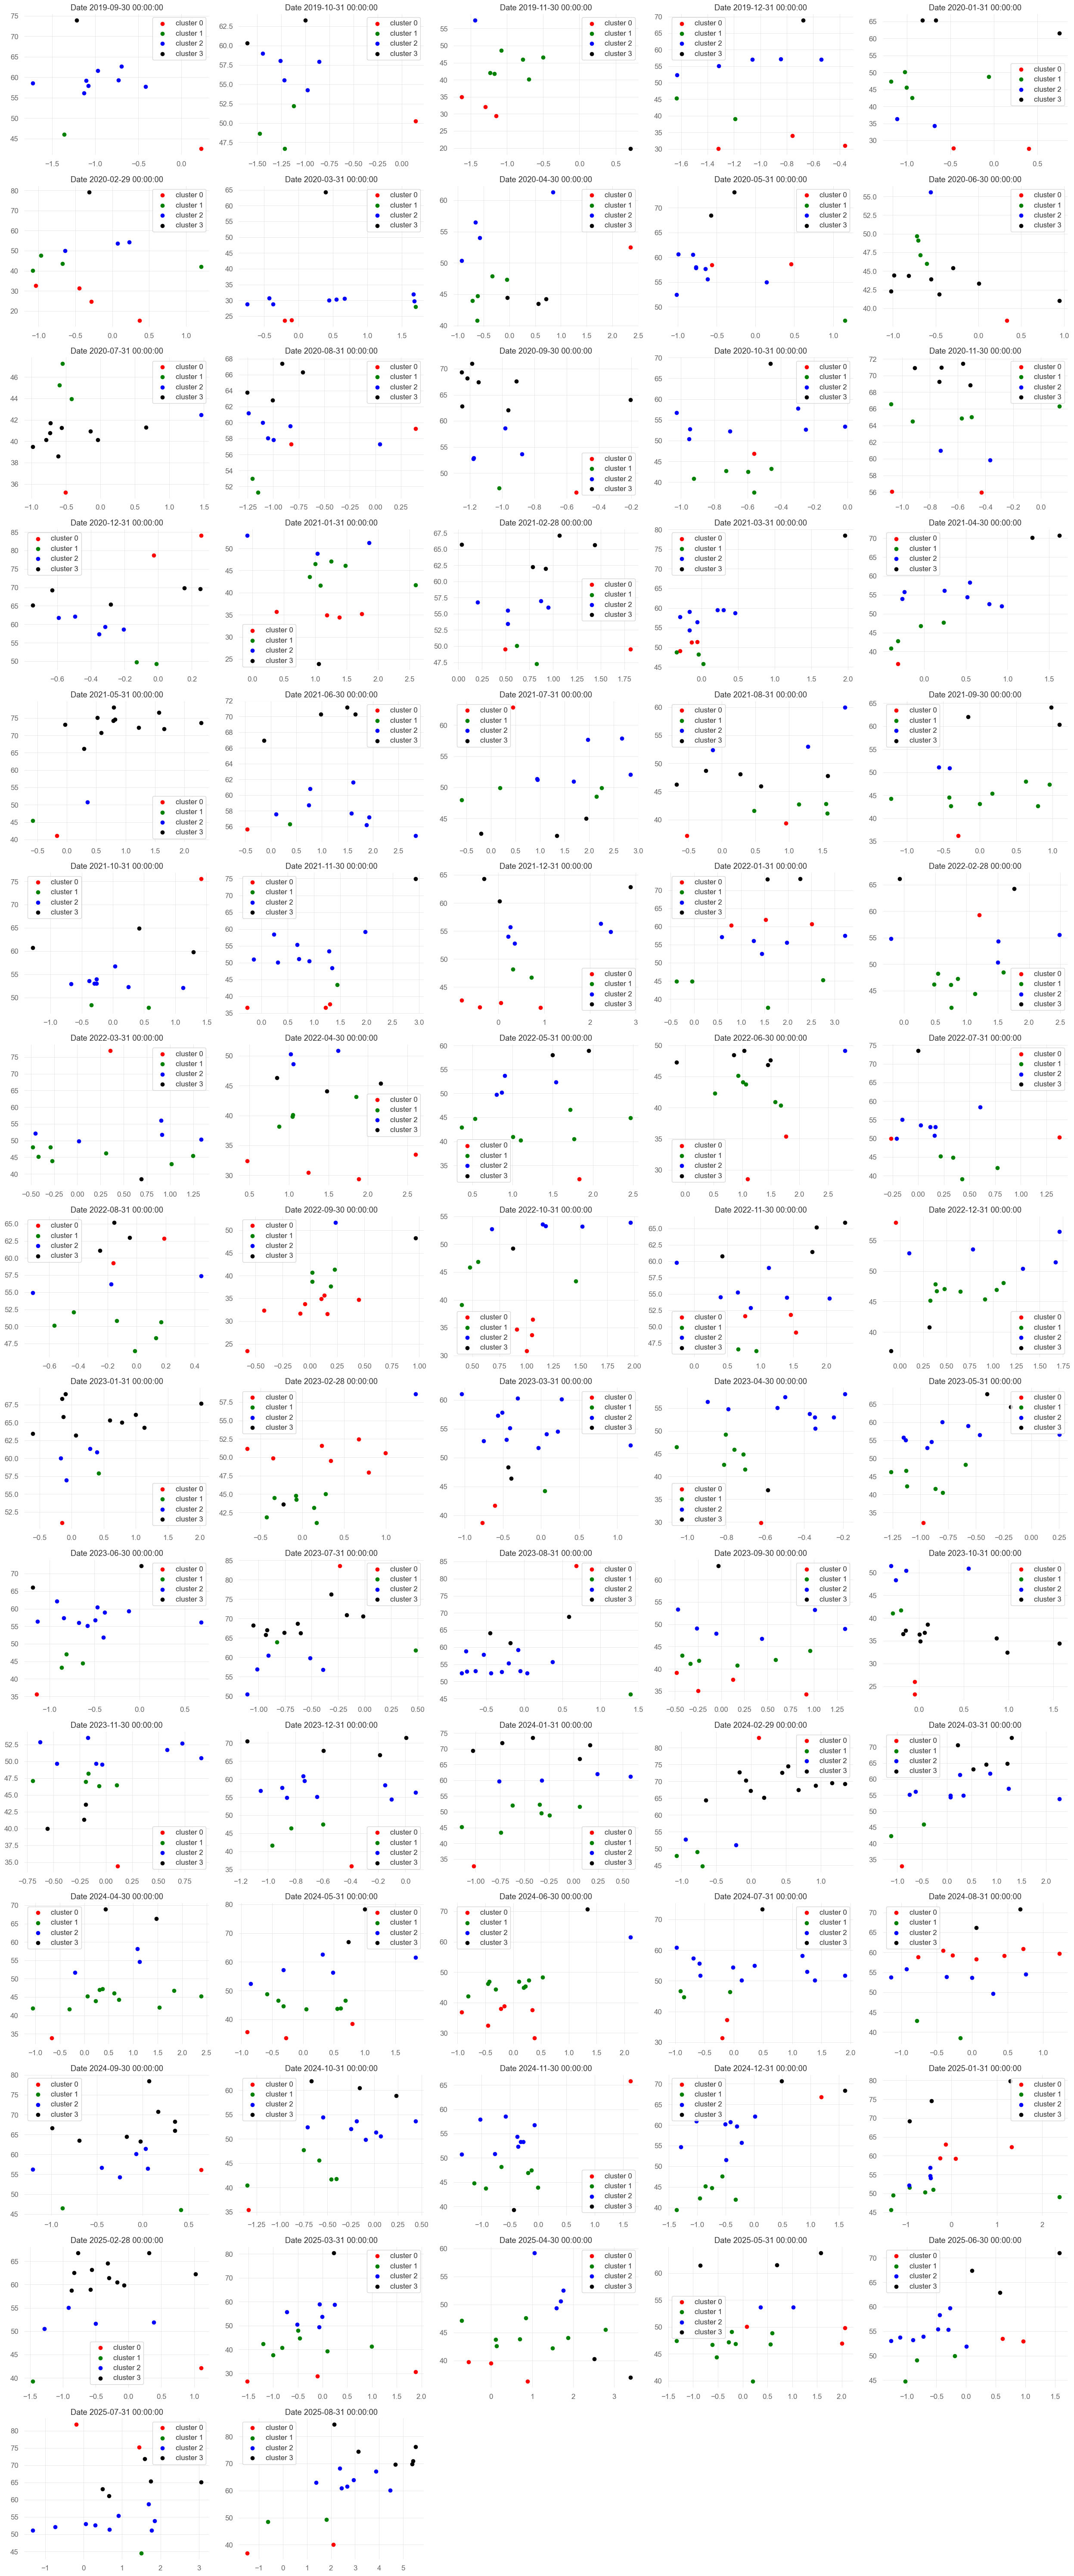

In [15]:
n_cols = 5
dates = data.index.get_level_values('date').unique().tolist()
n_rows = (len(dates) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for idx, i in enumerate(dates):
    g = data.xs(i, level=0)
    ax = axes[idx]
    ax.set_title(f'Date {i}')
    plot_clusters(g, ax=ax)

# xóa mấy subplot thừa
for j in range(len(dates), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Apply pre-defined centroids.

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [16]:
#filtered_df = data[data['cluster']==3].copy()
filtered_df = data[data['cluster'].isin([2, 3])].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2019-10-01': ['ACB.VN',
  'BID.VN',
  'CTG.VN',
  'FPT.VN',
  'GAS.VN',
  'MBB.VN',
  'SHB.VN',
  'SSI.VN',
  'VCB.VN'],
 '2019-11-01': ['ACB.VN',
  'BID.VN',
  'CTG.VN',
  'FPT.VN',
  'GAS.VN',
  'MBB.VN',
  'VCB.VN'],
 '2019-12-01': ['HPG.VN', 'SAB.VN'],
 '2020-01-01': ['BID.VN', 'CTG.VN', 'FPT.VN', 'HPG.VN', 'SHB.VN', 'VCB.VN'],
 '2020-02-01': ['BID.VN', 'CTG.VN', 'FPT.VN', 'SHB.VN', 'SSI.VN'],
 '2020-03-01': ['ACB.VN', 'CTG.VN', 'FPT.VN', 'SHB.VN'],
 '2020-04-01': ['ACB.VN',
  'BID.VN',
  'CTG.VN',
  'FPT.VN',
  'GAS.VN',
  'HPG.VN',
  'SHB.VN',
  'SSI.VN',
  'VCB.VN'],
 '2020-05-01': ['BID.VN',
  'FPT.VN',
  'GAS.VN',
  'HPG.VN',
  'SHB.VN',
  'SSI.VN',
  'VCB.VN'],
 '2020-06-01': ['ACB.VN',
  'BID.VN',
  'CTG.VN',
  'FPT.VN',
  'HDB.VN',
  'HPG.VN',
  'MBB.VN',
  'SSI.VN',
  'TPB.VN',
  'VCB.VN'],
 '2020-07-01': ['BID.VN',
  'CTG.VN',
  'FPT.VN',
  'GAS.VN',
  'HPG.VN',
  'MBB.VN',
  'SHB.VN',
  'TCB.VN',
  'VCB.VN'],
 '2020-08-01': ['BID.VN',
  'CTG.VN',
  'FPT.VN',
  'GAS.VN'

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [17]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [18]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                     auto_adjust = False)

new_df

[*********************100%***********************]  17 of 17 completed


Price          Adj Close                                             \
Ticker            ACB.VN        BID.VN        CTG.VN         FPT.VN   
Date                                                                  
2018-10-01   7653.140625  20262.958984  18755.521484   16608.611328   
2018-10-02   7562.302246  21108.464844  18790.189453   16355.872070   
2018-10-03   7607.721191  21370.863281  19067.535156   16428.082031   
2018-10-04   7721.269531  21429.173828  19206.208984   16554.453125   
2018-10-05   7630.431152  20700.289062  18790.189453   16464.187500   
...                  ...           ...           ...            ...   
2025-08-25  26200.000000  41000.000000  49100.000000   98800.000000   
2025-08-26  27350.000000  41800.000000  51200.000000  100000.000000   
2025-08-27  27650.000000  42800.000000  51100.000000  105000.000000   
2025-08-28  27550.000000  42500.000000  51600.000000  104500.000000   
2025-08-29  27800.000000  42850.000000  51300.000000  101600.000000   

Price                                                                        \
Ticker            GAS.VN        HDB.VN        HPG.VN   LPB.VN        MBB.VN   
Date                                                                          
2018-10-01  81223.289062  10548.956055  11732.490234      NaN   6283.754883   
2018-10-02  82513.625000  10495.408203  11428.109375      NaN   6229.350098   
2018-10-03  83328.570312  10562.342773  11428.109375      NaN   6283.754883   
2018-10-04  84211.437500  10374.924805  11455.780273      NaN   6528.576660   
2018-10-05  81494.937500  10174.120117  11469.616211      NaN   6446.969238   
...                  ...           ...           ...      ...           ...   
2025-08-25  64605.125000  31300.000000  25950.000000  45000.0  26200.000000   
2025-08-26  65357.437500  32300.000000  27200.000000  45500.0  27550.000000   
2025-08-27  64793.203125  32450.000000  26750.000000  43800.0  27400.000000   
2025-08-28  64900.000000  32500.000000  27100.000000  44850.0  27200.000000   
2025-08-29  63800.000000  33450.000000  27500.000000  45000.0  27750.000000   

Price                     ...     Volume                                    \
Ticker            SAB.VN  ...     LPB.VN    MBB.VN     SAB.VN       SHB.VN   
Date                      ...                                                
2018-10-01  95259.539062  ...        NaN  18335479   220560.0   35538349.0   
2018-10-02  96459.937500  ...        NaN  17454390  1106440.0   25375190.0   
2018-10-03  96760.039062  ...        NaN  12012883    34460.0   18957294.0   
2018-10-04  96888.648438  ...        NaN  75356610     9880.0   14653616.0   
2018-10-05  95688.250000  ...        NaN  26072915    44580.0   22115471.0   
...                  ...  ...        ...       ...        ...          ...   
2025-08-25  45600.000000  ...  5190265.0  56604310  1058238.0  113730100.0   
2025-08-26  45900.000000  ...  4294805.0  41262420   811277.0   87553640.0   
2025-08-27  46000.000000  ...  4345052.0  40405850  1276522.0  103905200.0   
2025-08-28  46550.000000  ...  2572691.0  32502880   639940.0  152877100.0   
2025-08-29  46550.000000  ...  3283105.0  55739760   830356.0  124465400.0   

Price                                                                \
Ticker         SSB.VN      SSI.VN      TCB.VN      TPB.VN    VCB.VN   
Date                                                                  
2018-10-01        NaN   5046090.0   6632200.0   1182382.0   4736967   
2018-10-02        NaN   5545668.0   7279500.0   1633185.0   3606980   
2018-10-03        NaN   4918861.0   2811660.0   2270140.0   2331567   
2018-10-04        NaN   6959755.0   8447760.0   3241459.0   5178851   
2018-10-05        NaN   6491875.0   6313120.0   2440552.0   3680154   
...               ...         ...         ...         ...       ...   
2025-08-25  5140466.0  69620200.0  41080510.0  59724430.0   7867628   
2025-08-26  2773790.0  94514410.0  36945660.0  49749940.0   8209194   
2025-08-27  3036488.0  5

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [19]:
# 1. Tính log returns
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date, cols in fixed_dates.items():
    try:
        # Xác định thời gian
        start_date = pd.to_datetime(start_date)
        end_date = (start_date + pd.offsets.MonthEnd(0))
        optimization_start_date = start_date - pd.DateOffset(months=12)
        optimization_end_date = start_date - pd.DateOffset(days=1)

        # Subset giá cho optimization
        optimization_df = new_df.loc[optimization_start_date:optimization_end_date, 'Adj Close'][cols]

        # 2. Optimize weights
        try:
            weights = optimize_weights(
                prices=optimization_df,
                lower_bound=round(1 / (len(optimization_df.columns) * 2), 3)
            )
            weights = pd.Series(weights, index=optimization_df.columns, name="weight")
        except:
            print(f"Optimization failed for {start_date.date()}, using Equal Weights")
            weights = pd.Series([1/len(optimization_df.columns)] * len(optimization_df.columns),
                                index=optimization_df.columns,
                                name="weight")

        # 3. Returns the month need test
        temp_df = returns_dataframe.loc[start_date:end_date, cols]

        # Multiply returns * weights
        weighted_returns = temp_df.mul(weights, axis=1).sum(axis=1).to_frame("Strategy Return")

        # Append into portfolio
        portfolio_df = pd.concat([portfolio_df, weighted_returns])

    except Exception as e:
        print(f"Error at {start_date}: {e}")

# Remove duplicate index nếu có
portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

portfolio_df


Optimization failed for 2019-10-01, using Equal Weights
Optimization failed for 2019-11-01, using Equal Weights
Optimization failed for 2019-12-01, using Equal Weights
Optimization failed for 2020-01-01, using Equal Weights
Optimization failed for 2020-02-01, using Equal Weights
Optimization failed for 2020-03-01, using Equal Weights
Optimization failed for 2020-04-01, using Equal Weights
Optimization failed for 2020-05-01, using Equal Weights
Optimization failed for 2020-07-01, using Equal Weights
Optimization failed for 2020-08-01, using Equal Weights
Optimization failed for 2020-11-01, using Equal Weights
Optimization failed for 2020-12-01, using Equal Weights
Optimization failed for 2021-02-01, using Equal Weights
Optimization failed for 2021-04-01, using Equal Weights
Optimization failed for 2021-05-01, using Equal Weights
Optimization failed for 2021-08-01, using Equal Weights
Optimization failed for 2021-09-01, using Equal Weights
Optimization failed for 2021-10-01, using Equal 

,Strategy Return
Date,
2019-10-01,0.008985
2019-10-02,-0.009475
2019-10-03,0.002697
2019-10-04,-0.017307
2019-10-07,-0.008899
...,...
2025-08-25,-0.028591
2025-08-26,0.038297
2025-08-27,-0.001712


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [20]:
vn30 = yf.download(tickers='E1VFVN30.VN',
                  start='2015-01-01',
                  end=dt.date.today(),
                  auto_adjust=False)

vn30_ret = np.log(vn30[['Adj Close']]).diff().dropna().rename({'Adj Close':'VN30 Buy&Hold'}, axis=1)

vn30_ret.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in vn30_ret.columns.values]

portfolio_df = portfolio_df.merge(vn30_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,VN30 Buy&Hold_E1VFVN30.VN
Date,,
2023-07-19,0.002554,0.005485
2023-07-20,-0.000164,-0.004985
2023-07-21,0.005494,0.011923
2023-07-24,0.004024,0.006890
2023-07-26,0.001519,0.007816
...,...,...
2025-08-25,-0.028591,-0.012520
2025-08-26,0.038297,0.021500
2025-08-27,-0.001712,0.009816


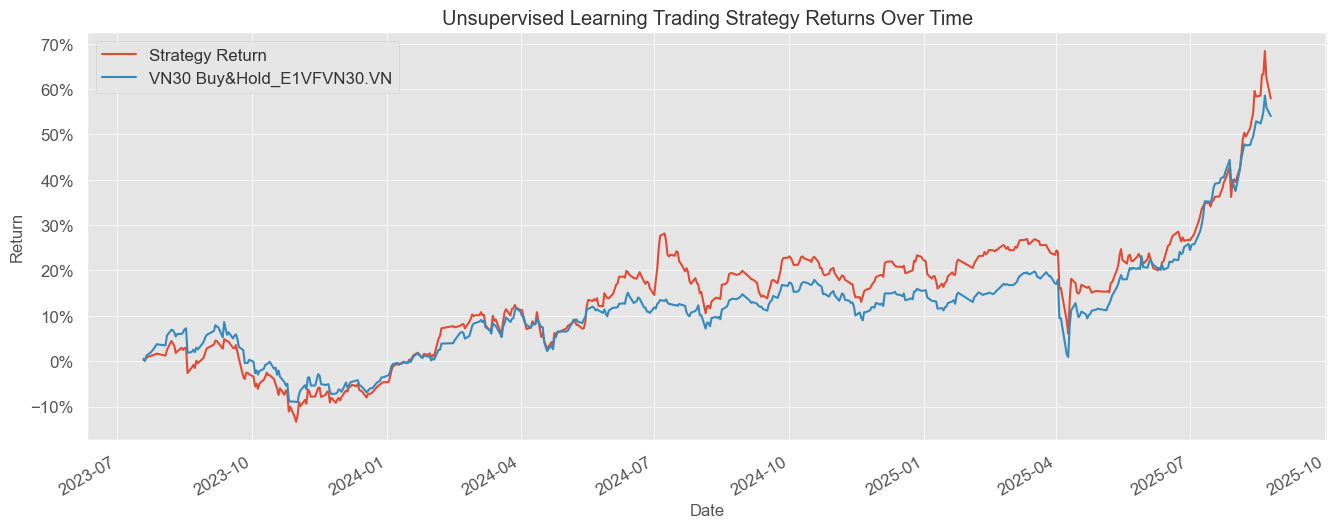

In [21]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2025-08-25'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


In [23]:
import quantstats as qs

qs.reports.html(portfolio_df['Strategy Return'],
                benchmark=portfolio_df['VN30 Buy&Hold_E1VFVN30.VN'],
                rf=0.035/252,
                title='Unsupervised Learning Trading Strategy Performance Report',
                download_filename="VN30_Unsupervised Learning Trading Strategy Performance Report"
               )